In [1]:
from collections import defaultdict
from pathlib import Path

import gurobipy as gp
import polars as pl
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from gurobipy import GRB

import os
import contextlib
import matplotlib.pyplot as plt


In [2]:
def get_data(data_dir: str, discount_factor: int = 5):
    df = pl.read_csv(
        Path(f"{data_dir}/alternatives.csv"), schema_overrides={"unit": pl.Int64}, infer_schema_length=1000
    )
    df = df.select(
        [
            "unit",
            "schedule",
            f"npv_{discount_factor}_percent",
            "stock_0",
            "stock_5",
            "stock_25",
            "harvest_value_5",
            "harvest_value_25",
            "stock_1_0",
            "stock_1_5",
            "stock_1_25",
            "stock_2_0",
            "stock_2_5",
            "stock_2_25",
            "stock_30_0",
            "stock_30_5",
            "stock_30_25",
        ]
    )
    df_keys = pl.read_csv(
        Path(f"{data_dir}/alternatives_key.csv"), schema_overrides={"unit": pl.Int64}, infer_schema_length=1000
    )
    df_keys = df_keys.drop("holding")
    # Split the treatments into multiple columns, to make them easier to read or whatever
    df_keys = df_keys.with_columns(
        [
            pl.when(pl.col("treatment").str.contains("_5"))
            .then(pl.col("treatment").str.extract(r"(\w+)_5", 1))
            .otherwise(pl.lit("donothing"))
            .alias("treatment_5"),
            pl.when(pl.col("treatment").str.contains("_25"))
            .then(pl.col("treatment").str.extract(r"(\w+)_25", 1))
            .otherwise(pl.lit("donothing"))
            .alias("treatment_25"),
        ]
    )

    df = df_keys.join(df, on=["unit", "schedule"], how="inner")
    return df


def get_scenario_data(data_dir: str):
    return pl.read_csv(Path(f"{data_dir}/scenario.csv"), schema_overrides={"unit": pl.Int64}, infer_schema_length=1000)

In [3]:
def tsrmop_asf(reference: dict, outputflag: int = 0):
    """This is the robust two stage model."""
    model = gp.Model()
    model.setParam("OutputFlag", outputflag)
    model.setParam("MIPGap", 1e-5)

    discount_factor = 5
    data_dirs = [
        "C:/MyTemp/data/two_stage_data/l1l23",
        "C:/MyTemp/data/two_stage_data/h1h23",
        "C:/MyTemp/data/two_stage_data/l1h23",
        "C:/MyTemp/data/two_stage_data/h1l23",
    ]
    n_scenarios = len(data_dirs)

    ideals = {
            "harvest5": 83939.39118553553,
            "harvest25": 425351.15530470666,
            "stock": 5985.184367164438,
            "npv": 310523.6483315748,
        }
    nadirs = {"harvest5": 0, "harvest25": 0, "stock": 260.7007001702532, "npv": 52844.33156539744}

    rho = 1e-6
    alpha = model.addVar(lb=-float("inf"))
    alphacons = [[],[],[],[]]
    normalsum = 0
    hsum5 = []
    hsum25 = []
    npvsum = []
    stocksum = []
    mvars = []
    unitsums = []
    harvest5 = []
    harvest25 = []
    stock = []
    npv = []
    x0_vars = {}
    x0_unit_sum = defaultdict(float)

    for i in range(n_scenarios):
        hsum5.append(0)
        hsum25.append(0)
        npvsum.append(0)
        stocksum.append(0)
        mvars.append({})
        unitsums.append(defaultdict(float))

        # df = get_data(data_dirs[i], discount_factor=discount_factor)
        df = get_scenario_data(data_dirs[i])

        for row in df.iter_rows(named=True):
            if (row["unit"], row["treatment_5"]) not in x0_vars:
                x0_vars[(row["unit"], row["treatment_5"])] = model.addVar(vtype=GRB.BINARY)
                x0_unit_sum[row["unit"]] += x0_vars[(row["unit"], row["treatment_5"])]
            new_var = model.addVar(vtype=GRB.BINARY)
            mvars[i][(row["unit"], row["treatment_5"], row["treatment_25"])] = new_var
            hsum5[i] += new_var * row["harvest_value_5"]
            hsum25[i] += new_var * row["harvest_value_25"]
            npvsum[i] += new_var * row[f"npv_{discount_factor}_percent"]
            stocksum[i] += new_var * row["stock_25"]
            unitsums[i][(row["unit"], row["treatment_5"])] += new_var

        for key in unitsums[i]:
            model.addConstr(unitsums[i][key] == x0_vars[key])

        harvest5.append(model.addVar())
        model.addConstr(harvest5[i] == hsum5[i])
        harvest25.append(model.addVar())
        model.addConstr(harvest25[i] == hsum25[i])
        stock.append(model.addVar())
        model.addConstr(stock[i] == stocksum[i])
        npv.append(model.addVar())
        model.addConstr(npv[i] == npvsum[i])

        objectives = {"harvest5": harvest5[i], "harvest25": harvest25[i], "stock": stock[i], "npv": npv[i]}

        normalsum = 0
        for obj in objectives:  # noqa: PLC0206
            normalsum += (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj])

        for obj in objectives:  # noqa: PLC0206
            alphacons[i].append(
                model.addConstr(
                    alpha >= (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj]) + rho * normalsum
                )
            )
            ##normalsum += objectives[obj] / (nadirs[obj] - ideals[obj])
        # model.addConstr(alpha >= -npv[i] + rho*normalsum)

    for unitsum in x0_unit_sum.values():
        model.addConstr(unitsum == 1)

    # model.setObjective(alpha + rho * normalsum, sense=GRB.MINIMIZE)
    model.setObjective(alpha, sense=GRB.MINIMIZE)
    model.optimize()
    worst_case = 0
    worst_value = -1e20
    for i in range(n_scenarios):
        for j in range(len(objectives)):
            #print(alphacons[i][j].Slack)
            if alphacons[i][j].Slack >= worst_value:
                worst_case = i+1
                worst_value = alphacons[i][j].Slack


    return (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)


In [4]:
def rmop_asf(reference: dict, outputflag: int=0):
    """This is the robust single stage model."""
    model = gp.Model()
    model.setParam('OutputFlag', outputflag)
    model.setParam("MIPGap", 1e-5)

    discount_factor = 5
    data_dirs = [
        "C:/MyTemp/data/two_stage_data/l1l23",
        "C:/MyTemp/data/two_stage_data/h1h23",
        "C:/MyTemp/data/two_stage_data/l1h23",
        "C:/MyTemp/data/two_stage_data/h1l23",
    ]
    n_scenarios = len(data_dirs)

    ideals = {
            "harvest5": 83939.39118553553,
            "harvest25": 425351.15530470666,
            "stock": 5985.184367164438,
            "npv": 310523.6483315748,
        }
    nadirs = {"harvest5": 0, "harvest25": 0, "stock": 260.7007001702532, "npv": 52844.33156539744}

    rho = 1e-6
    alpha = model.addVar(lb=-float("inf"))
    alphacons = [[],[],[],[]]
    normalsum = 0
    hsum5 = []
    hsum25 = []
    npvsum = []
    stocksum = []
    mvars = []
    unitsums = []
    harvest5 = []
    harvest25 = []
    stock = []
    npv = []
    x0_vars = {}
    x0_unit_sum = defaultdict(float)

    for i in range(n_scenarios):
        hsum5.append(0)
        hsum25.append(0)
        npvsum.append(0)
        stocksum.append(0)
        mvars.append({})
        unitsums.append(defaultdict(float))

        # df = get_data(data_dirs[i], discount_factor=discount_factor)
        df = get_scenario_data(data_dirs[i])

        for row in df.iter_rows(named=True):
            #if (row["unit"], row["treatment_5"]) not in x0_vars:
            #    x0_vars[(row["unit"], row["treatment_5"])] = model.addVar(vtype=GRB.BINARY)
            #    x0_unit_sum[row["unit"]] += x0_vars[(row["unit"], row["treatment_5"])]
            if (row["unit"], row["treatment"]) not in x0_vars:
                x0_vars[(row["unit"], row["treatment"])] = model.addVar(vtype=GRB.BINARY)
                x0_unit_sum[row["unit"]] += x0_vars[(row["unit"], row["treatment"])]
            new_var = x0_vars[(row["unit"], row["treatment"])]
            mvars[i][(row["unit"], row["treatment_5"], row["treatment_25"])] = new_var
            hsum5[i] += new_var * row["harvest_value_5"]
            hsum25[i] += new_var * row["harvest_value_25"]
            npvsum[i] += new_var * row[f"npv_{discount_factor}_percent"]
            stocksum[i] += new_var * row["stock_25"]
            #unitsums[i][(row["unit"], row["treatment_5"])] += new_var

        #for key in unitsums[i]:
        #    model.addConstr(unitsums[i][key] == x0_vars[key])

        harvest5.append(model.addVar())
        model.addConstr(harvest5[i] == hsum5[i])
        harvest25.append(model.addVar())
        model.addConstr(harvest25[i] == hsum25[i])
        stock.append(model.addVar())
        model.addConstr(stock[i] == stocksum[i])
        npv.append(model.addVar())
        model.addConstr(npv[i] == npvsum[i])

        objectives = {"harvest5": harvest5[i], "harvest25": harvest25[i], "stock": stock[i], "npv": npv[i]}

        normalsum = 0
        for obj in objectives:  # noqa: PLC0206
            normalsum += (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj])

        for obj in objectives:  # noqa: PLC0206
            alphacons[i].append(
                model.addConstr(
                    alpha >= (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj]) + rho * normalsum
                )
            )
            ##normalsum += objectives[obj] / (nadirs[obj] - ideals[obj])
        # model.addConstr(alpha >= -npv[i] + rho*normalsum)

    for unitsum in x0_unit_sum.values():
        model.addConstr(unitsum == 1)

    # model.setObjective(alpha + rho * normalsum, sense=GRB.MINIMIZE)
    model.setObjective(alpha, sense=GRB.MINIMIZE)
    model.optimize()
    worst_case = 0
    worst_value = -1e20
    for i in range(n_scenarios):
        for j in range(len(objectives)):
            print(alphacons[i][j].Slack)
            if alphacons[i][j].Slack >= worst_value:
                worst_case = i+1
                worst_value = alphacons[i][j].Slack
    return (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) 

In [5]:
reference = {
            "harvest5": -1183939.39118553553,
            "harvest25": -11417274.83027785446,
            "stock": -115914.54505892277,
            "npv": 11308305.7407073733,
        }


(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) = tsrmop_asf(reference=reference,outputflag=1)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


print(model.ObjVal)
print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)


Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-18


Set parameter OutputFlag to value 1
Set parameter MIPGap to value 1e-05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1245U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  1e-05

Optimize a model with 274 rows, 992 columns and 4351 nonzeros
Model fingerprint: 0x7d87511f
Variable types: 17 continuous, 975 integer (975 binary)
Coefficient statistics:
  Matrix range     [2e-12, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 101 rows and 267 columns
Presolve time: 0.02s
Presolved: 173 rows, 725 columns, 2126 nonzeros
Variable types: 4 continuous, 721 integer (721 binary)
Found heuristic solution: objective 43.4071964
Found heuristic s

In [6]:
labels = ["harvest5", "harvest25", "npv", "stock"]
namedict = {"harvest5": "Income 0", "harvest25": "Income 20", "stock": "Final timber volume", "npv": "NPV"}
ideals = {
        "harvest5": 83939.39118553553,
        "harvest25": 425351.15530470666,
        "stock": 5985.184367164438,
        "npv": 310523.6483315748,
    }
nadirs = {"harvest5": 0, "harvest25": 0, "stock": 260.7007001702532, "npv": 52844.33156539744}

for xi in range(3):
    for yi in range(xi + 1, 4):
        xlabel = labels[xi]
        ylabel = labels[yi]

        objective_values = {label: [] for label in labels}

        for i in range(21):
            weight = i / 20
            """
            reference = {
                    "harvest5": weight*ideals["harvest5"]+(1-weight)*nadirs["harvest5"],
                    "harvest25": (1-weight)*ideals["harvest25"]+weight*nadirs["harvest25"],
                    "stock": nadirs["stock"],
                    "npv": nadirs["npv"],
                }
                """
            reference = {}
            for label in labels:
                if label == xlabel:
                    reference[label] = weight * ideals[label] + (1 - weight) * nadirs[label]
                elif label == ylabel:
                    reference[label] = (1 - weight) * ideals[label] + weight * nadirs[label]
                else:
                    reference[label] = -ideals[label]

            (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) = tsrmop_asf(reference=reference)
            print(f"Worst scenario ={worst_case}")
            # (model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)
            results = {"harvest5": harvest5, "harvest25": harvest25, "stock": stock, "npv": npv}

            for label in labels:
                objective_values[label].append(min(var.x for var in results[label]))

            if np.isclose(min(var.x for var in results[xlabel]), ideals[xlabel]):
                break

        """
            print(model.ObjVal)
            print("Harvest 5")
            print(harvest5[0].x)
            print(harvest5[1].x)
            print(harvest5[2].x)
            print(harvest5[3].x)
            print("harvest 25")
            print(harvest25[0].x)
            print(harvest25[1].x)
            print(harvest25[2].x)
            print(harvest25[3].x)
            print("stock")
            print(stock[0].x)
            print(stock[1].x)
            print(stock[2].x)
            print(stock[3].x)
            print("NPV")
            print(npv[0].x)
            print(npv[1].x)
            print(npv[2].x)
            print(npv[3].x)
            print()
        """

        data = np.array([objective_values[label] for label in labels]).transpose()

        ideal_vals = np.array([ideals[label] for label in labels])
        nadir_vals = np.array([nadirs[label] for label in labels])
        normed = (data - nadir_vals) / (ideal_vals - nadir_vals)

        # Plot each row as a line
        for row in normed:
            plt.plot(range(data.shape[1]), row)

        plt.xticks(range(normed.shape[1]), [namedict[label] for label in labels])

        # plt.plot(x, y, marker='.', linestyle='None')
        # plt.title("Pareto frontier")
        plt.savefig(f"figures/pcp_{xlabel}_{ylabel}.png", dpi=300, bbox_inches="tight")
        # plt.show()
        plt.close()

        plt.plot(objective_values[xlabel], objective_values[ylabel], marker=".", linestyle="None")
        plt.xlabel(namedict[xlabel])
        plt.ylabel(namedict[ylabel])

        # plt.title("Pareto frontier")
        plt.savefig(f"figures/scatter_{xlabel}_{ylabel}.png", dpi=300, bbox_inches="tight")
        # plt.show()
        plt.close()

Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =4
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =2
Worst scenario =2
Worst scenario =2
Worst scenario =4
Worst scenario =4
Worst scenario =2
Worst scenario =2
Worst scenario =4
Worst scenario =4
Worst scenario =3
Worst scenario =4
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scenario =3
Worst scen

In [7]:

rand_rmop = []
rand_tsrmop = []
rand_alphadiff = []

for i in range(101):
    arr = np.random.rand(4)
    reference = {
        "harvest5": arr[0] * ideals["harvest5"] + (1 - arr[0]) * nadirs["harvest5"],
        "harvest25": arr[1] * ideals["harvest25"] + (1 - arr[1]) * nadirs["harvest25"],
        "stock": arr[2] * ideals["stock"] + (1 - arr[2]) * nadirs["stock"],
        "npv": arr[3] * ideals["npv"] + (1 - arr[3]) * nadirs["npv"],
    }
    (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference)
    rand_tsrmop.append(
        [
            min(var.x for var in harvest5),
            min(var.x for var in harvest25),
            min(var.x for var in npv),
            min(var.x for var in stock),
        ]
    )
    rand_alphadiff.append(-alpha.x)
    (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = rmop_asf(reference)
    rand_rmop.append(
        [
            min(var.x for var in harvest5),
            min(var.x for var in harvest25),
            min(var.x for var in npv),
            min(var.x for var in stock),
        ]
    )
    rand_alphadiff[-1] += alpha.x
    print(i)
    

-0.0009635443804401067
-0.6238810014380796
-0.03628968728971671
-0.2628469071043966
-0.00096349122368522
-0.7361490184294034
-0.025682149912827912
-0.10802951309922637
-0.0009632395459163723
-0.5982598194835306
-0.01904749102793346
-0.0008748470637788275
-0.0009634865068626208
-0.7578091827912812
-0.0
-0.10733466184725726
0
-0.0007588380019560859
-0.5040366298314375
-0.043156246813918164
-0.2775027612349572
-0.0007586705185032017
-0.5518391762532011
-0.00015760102223971728
-0.10521490522594301
-0.0007585152889406643
-0.4992322267771207
-0.002749427578110364
-0.0
-0.0007586373756042208
-0.5361000188075349
-0.0030027379623069894
-0.08496592739729969
1
-0.0008403457197849185
-0.02913186530151335
-0.01844392993600523
-0.596796743240316
-0.0008404701576267548
-0.18506244080759027
-0.014055620078266454
-0.5696926927466269
-0.0008401668547481922
-0.0
-0.011664625647720306
-0.4538423395075145
-0.0008404676035121961
-0.19792849293937054
-2.2544665465668023e-05
-0.5683055938305063
2
-0.000498709

In [8]:
import statistics
print(statistics.mean(rand_alphadiff))
print(max(rand_alphadiff))

0.004547417531022409
0.014627772771795194


In [9]:
reference = ideals


(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)

print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

Harvest 5
39531.31372379564
harvest 25
197137.7084990426
stock
2915.963930230543
NPV
181569.09517359862
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
39531.31372379564
39531.31372379564
39531.31372379564
39531.31372379564
harvest 25
208247.19374422473
215495.9620383306
197137.7084990426
201303.29165768364
stock
2983.1251720029954
2993.9506809867607
2915.963930230543
3102.1920907068215
NPV
197351.72603637638
187619.59380705797
181569.09517359862
185219.176043692


In [10]:
reference = {
    "harvest5": 0,
    "harvest25": 0,
    "stock": 0,
    "npv": 310524,
}

(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)

print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

Harvest 5
3243.622737551953
harvest 25
424490.9513276124
stock
260.70070017025324
NPV
310523.6483315748
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
3243.622737551953
3243.622737551953
3243.622737551953
3243.622737551953
harvest 25
429260.39509247773
480090.37323811516
424490.9513276124
477030.9605001443
stock
425.84181948310004
618.6776490713889
260.70070017025324
745.2295636190084
NPV
313665.59943547705
322462.7336724805
310523.6483315748
320697.8747409887


In [11]:
reference = {
    "harvest5": 20000,
    "harvest25": 0,
    "stock": 1000,
    "npv": 250000,
}

(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)

print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

Harvest 5
24822.59999952213
harvest 25
324964.80960942956
stock
1326.631101015343
NPV
265493.63253324677
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
24822.599999522157
24822.599999522157
24822.59999952213
24822.599999522154
harvest 25
333597.3936231176
358545.03457862436
324964.80960942956
394010.24042303744
stock
1412.2060284722193
1638.230301596694
1326.631101015343
1346.7683995405973
NPV
279678.36429581116
266125.74687763624
265493.63253324677
271111.08669062995


In [12]:
reference = {
    "harvest5": 30000,
    "harvest25": 0,
    "stock": 1000,
    "npv": 280000,
}

(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)

print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

Harvest 5
27800.3233121971
harvest 25
355943.56702341704
stock
871.5159878233891
NPV
273272.2886627424
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
27800.323312197095
27800.3233121971
27800.3233121971
27800.3233121971
harvest 25
360036.60842227965
414584.16678974713
355943.56702341704
419460.2155865445
stock
917.6399836179924
1020.1145964851817
871.5159878233891
939.8910955924553
NPV
293068.58326289605
281232.8881527557
273272.2886627424
281282.7332259253


In [13]:
for scenario in range(4):
    print(f"Scenario {scenario+1}")
    for key, value in mvars[scenario].items():
        if value.x != 0:
            print(f"Stand: {key[0]-43124559} First action: {key[1]} Second action: {key[2]}")

Scenario 1
Stand: 0 First action: donothing Second action: donothing
Stand: 1 First action: donothing Second action: clearcut
Stand: 2 First action: donothing Second action: even
Stand: 3 First action: donothing Second action: above
Stand: 4 First action: donothing Second action: clearcut
Stand: 5 First action: donothing Second action: above
Stand: 6 First action: even Second action: below
Stand: 7 First action: donothing Second action: clearcut
Stand: 8 First action: above Second action: clearcut
Stand: 9 First action: donothing Second action: clearcut
Stand: 10 First action: clearcut Second action: first
Stand: 11 First action: donothing Second action: above
Stand: 12 First action: even Second action: donothing
Stand: 13 First action: above Second action: clearcut
Stand: 14 First action: donothing Second action: first
Stand: 15 First action: above Second action: clearcut
Stand: 16 First action: donothing Second action: donothing
Stand: 17 First action: donothing Second action: clearc

In [14]:
'''
tsr_f1_arvot = [1e6]*101
tsr_f2_arvot = [1e6]*101
r_f1_arvot = [1e6]*101
r_f2_arvot = [1e6]*101
diff_f1 = [0]*101
diff_f2 = [0]*101
alphas = [0]*101
# heitetään tulosteet roskiin
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    for i in range(0,101):
        reference = {
            "harvest5": -1e5,
            "harvest25": -1e5,
            "stock": 5914.54505892277*i/100+(100-i)/100*277.3128133588118,
            "npv": 308305.7407073733*(100-i)/100+i/100*137635.7828109703,
        }

        (model, harvest5, harvest25, stock, npv, alpha) = tsrmop_asf(reference=reference)
        for s in stock:
            tsr_f1_arvot[i] = min(s.x,tsr_f1_arvot[i])
        for n in npv:
            tsr_f2_arvot[i] = min(n.x,tsr_f2_arvot[i])

        alphas[i]=alpha

        (model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)
        for s in stock:
            r_f1_arvot[i] = min(s.x,r_f1_arvot[i])
        for n in npv:
            r_f2_arvot[i] = min(n.x,r_f2_arvot[i])
        diff_f1[i] = (tsr_f1_arvot[i] - r_f1_arvot[i])/(5914.54505892277-277.3128133588118)
        diff_f2[i] = (tsr_f2_arvot[i] - r_f2_arvot[i])/(308305.7407073733-137635.7828109703)
        alphas[i] = alphas[i]-alpha
        
'''



'\ntsr_f1_arvot = [1e6]*101\ntsr_f2_arvot = [1e6]*101\nr_f1_arvot = [1e6]*101\nr_f2_arvot = [1e6]*101\ndiff_f1 = [0]*101\ndiff_f2 = [0]*101\nalphas = [0]*101\n# heitetään tulosteet roskiin\nwith open(os.devnull, \'w\') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):\n    for i in range(0,101):\n        reference = {\n            "harvest5": -1e5,\n            "harvest25": -1e5,\n            "stock": 5914.54505892277*i/100+(100-i)/100*277.3128133588118,\n            "npv": 308305.7407073733*(100-i)/100+i/100*137635.7828109703,\n        }\n\n        (model, harvest5, harvest25, stock, npv, alpha) = tsrmop_asf(reference=reference)\n        for s in stock:\n            tsr_f1_arvot[i] = min(s.x,tsr_f1_arvot[i])\n        for n in npv:\n            tsr_f2_arvot[i] = min(n.x,tsr_f2_arvot[i])\n\n        alphas[i]=alpha\n\n        (model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)\n        for s in stock:\n            r_f1_arvot[i] = min(s.x,r_f1

In [15]:
#plt.plot(tsr_f1_arvot[40:61], tsr_f2_arvot[40:61], marker='.', linestyle='-',color='red')
#plt.plot(r_f1_arvot[40:61], r_f2_arvot[40:61], marker='.', linestyle='-',color='blue')
#plt.plot(diff_f1, diff_f2, marker='.', linestyle='None')
#plt.title("Pareto frontier")
#plt.show()
#plt.savefig('image.png')

In [16]:
reference = {
    "harvest5": 0,
    "harvest25": 0,
    "stock": 0,
    "npv": 1000000,
}

(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)
print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

Harvest 5
3243.622737551953
harvest 25
424490.9513276124
stock
260.7007001702532
NPV
310523.6483315748
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
3243.622737551953
3243.622737551953
3243.622737551953
3243.622737551953
harvest 25
415204.7476931632
472981.281089882
424490.9513276124
484964.057924659
stock
671.7671469640364
686.7775092328045
260.7007001702532
606.9994584971819
NPV
313011.3498190064
317953.3857302591
310523.6483315748
322615.0479927271


-0.9999999383058027
-0.9999999383058027
-0.06946749913698835
-0.3400064164757203
-1.0000000000000002
-1.0000000000000002
-0.0
-0.4711682364711536
-0.999999896190403
-0.999999896190403
-0.01390136661131125
-0.35345706510116726
-1.0000000043779844
-1.0000000043779844
-0.017741198117262158
-0.45780503140271656
--------------------------------------------
-0.9666666049724695
-0.9666666049724695
-0.06946749913698835
-0.2733397498090536
-0.9666666666666669
-0.9666666666666669
-0.0
-0.40450156980448704
-0.9666665628570698
-0.9666665628570698
-0.01390136661131125
-0.2867903984345007
-0.9666666710446512
-0.9666666710446512
-0.017741198117262158
-0.39113836473605
--------------------------------------------
-0.9333332716391357
-0.9333332716391357
-0.06946749913698835
-0.20667308314238653
-0.9333333333333331
-0.9333333333333331
-0.0
-0.3378349031378199
-0.933333229523736
-0.933333229523736
-0.01390136661131125
-0.22012373176783362
-0.9333333377113174
-0.9333333377113174
-0.017741198117262158
-0.3

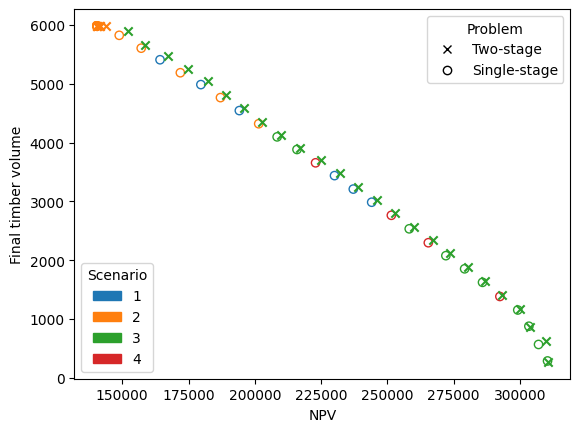

In [ ]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

labels = ["harvest5", "harvest25", "npv", "stock"]
namedict = {"harvest5": "Income 0", "harvest25": "Income 20", "stock": "Timber remaining", "npv": "NPV"}
ideals = {
        "harvest5": 83939.39118553553,
        "harvest25": 425351.15530470666,
        "stock": 5985.184367164438,
        "npv": 310523.6483315748,
    }
nadirs = {"harvest5": 0, "harvest25": 0, "stock": 260.7007001702532, "npv": 52844.33156539744}


objective_values = {label: [] for label in labels}
objective_values_rmop = {label: [] for label in labels}
xlabel = "npv"
ylabel = "stock"

npoints = 30
alphas_ts = []
alphas_rmop = []
worst_case_ts = []
worst_case_rmop = []
weights = []
for i in range(npoints+1):
    weight = i / npoints
    weights.append(weight)
    """
    reference = {
            "harvest5": weight*ideals["harvest5"]+(1-weight)*nadirs["harvest5"],
            "harvest25": (1-weight)*ideals["harvest25"]+weight*nadirs["harvest25"],
            "stock": nadirs["stock"],
            "npv": nadirs["npv"],
        }
        """
    reference = {}
    for label in labels:
        if label == xlabel:
            reference[label] = weight * ideals[label] + (1 - weight) * nadirs[label]
        elif label == ylabel:
            reference[label] = (1 - weight) * ideals[label] + weight * nadirs[label]
        else:
            reference[label] = -ideals[label]

    (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) = tsrmop_asf(reference=reference)
    alphas_ts.append(alpha)
    worst_case_ts.append(worst_case)

    results = {"harvest5": harvest5, "harvest25": harvest25, "stock": stock, "npv": npv}

    for label in labels:
        objective_values[label].append(min(var.x for var in results[label]))

    (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) = rmop_asf(reference=reference)
    alphas_rmop.append(alpha)
    worst_case_rmop.append(worst_case)

    #print(f"Worst scenario ={worst_case}")
    # (model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)
    results = {"harvest5": harvest5, "harvest25": harvest25, "stock": stock, "npv": npv}

    for label in labels:
        objective_values_rmop[label].append(min(var.x for var in results[label]))

    print("--------------------------------------------")
    #if np.isclose(min(var.x for var in results[xlabel]), ideals[xlabel]):
    #    break

"""
    print(model.ObjVal)
    print("Harvest 5")
    print(harvest5[0].x)
    print(harvest5[1].x)
    print(harvest5[2].x)
    print(harvest5[3].x)
    print("harvest 25")
    print(harvest25[0].x)
    print(harvest25[1].x)
    print(harvest25[2].x)
    print(harvest25[3].x)
    print("stock")
    print(stock[0].x)
    print(stock[1].x)
    print(stock[2].x)
    print(stock[3].x)
    print("NPV")
    print(npv[0].x)
    print(npv[1].x)
    print(npv[2].x)
    print(npv[3].x)
    print()
"""

data = np.array([objective_values[label] for label in labels]).transpose()

ideal_vals = np.array([ideals[label] for label in labels])
nadir_vals = np.array([nadirs[label] for label in labels])
normed = (data - nadir_vals) / (ideal_vals - nadir_vals)

plt.close()


# Pick a colorblind-friendly palette
unique_cats = [1, 2, 3, 4]
cmap = plt.get_cmap("tab10")
colors = {cat: cmap(i) for i, cat in enumerate(unique_cats)}

xvals = objective_values_rmop[xlabel]
yvals = objective_values_rmop[ylabel]
cats  = worst_case_rmop   # make sure this is just a list of ints

for cat in unique_cats:
    # mask is just a list of booleans now
    mask = [c == cat for c in cats]
    if not any(mask):
        continue

    # pick only the points where mask is True
    x_masked = [x for x, m in zip(xvals, mask) if m]
    y_masked = [y for y, m in zip(yvals, mask) if m]

    g=plt.scatter(x_masked, y_masked,
                label=f"Scenario {cat}",
                color=colors[cat],
                marker="o")
    g.set_facecolor('none')
    
    
xvals = objective_values[xlabel]
yvals = objective_values[ylabel]
cats  = worst_case_ts   # make sure this is just a list of ints

for cat in unique_cats:
    # mask is just a list of booleans now
    mask = [c == cat for c in cats]
    if not any(mask):
        continue

    # pick only the points where mask is True
    x_masked = [x for x, m in zip(xvals, mask) if m]
    y_masked = [y for y, m in zip(yvals, mask) if m]

    plt.scatter(x_masked, y_masked,
                label=f"Scenario {cat}",
                color=colors[cat],
                marker="x")

# First legend: colors (scenarios)
color_handles = [
    mpatches.Patch(color=colors[cat], label=f"{cat}")
    for cat in unique_cats
]

# Second legend: markers (dataset types)
marker_handles = [
    mlines.Line2D([], [], color="black", marker="x", linestyle="None", label="Two-stage"),
    mlines.Line2D([], [], color="white", markeredgecolor="black", marker="o", linestyle="None", label="Single-stage", markerfacecolor=None, markeredgewidth=1, markerfacecoloralt=None),
]

# Add them separately
first_legend = plt.legend(handles=color_handles, title="Scenario", loc="lower left")
plt.gca().add_artist(first_legend)  # keep first legend when adding another
plt.legend(handles=marker_handles, title="Problem", loc="upper right")

plt.xlabel(namedict[xlabel])
plt.ylabel(namedict[ylabel])

# plt.title("Pareto frontier")
plt.savefig(f"figures/something_{xlabel}_{ylabel}.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()